In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np

plt.style.use('dark_background')
fig = plt.figure()
fig.set_size_inches(10,10)

<Figure size 720x720 with 0 Axes>

In [ ]:
x = np.linspace(0, 20, 50)

Here we provide the variable data for a 2-dimensional trajectory and get its projected flight time and range in meters. This section also validates the varables to compare them with expected flight times to prevent unusable data. Finally a vector of the induvidual velocity components is displayed. Since this is a planar simulation only the x and z components return.
_________________
**Horizontal** **Velocity**: initial velocity * cosine of angle
_________________
**Vertical** **Velocity**: initial velocity * sine of angle
_________________
**Trajectory** **Graph**: (altitude + x * tangent of angle) - (gravity * x^2) / (2 * velocity^2 * cosine of angle^2)
_________________
**Flight** **Time**: (initial velocity * sine of angle) + square root of ((initial velocity * sine of angle)^2 + (2 * gravity * altitude) / gravity)

flightTime: 2.026183003098741
timeCode: CHECK
Range: 17.547259533997536
Velocity [ q, x, y, z]
[ 0, 8.66, 0, 5.0]


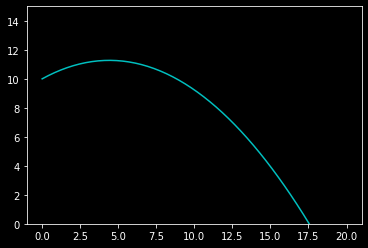

In [ ]:
vel = 10 # velocity
acc = 0 # acceleration
alt = 10 # start height
ang = (30 * np.pi) / 180 # launch angle (deg)
gra = 9.807 # gravity
v0 = vel # initial velocity
Vx0 = v0 * np.cos(ang)
Vz0 = v0 * np.sin(ang)
v1 = 20 # final velocity

def calc(x):
  arch = (alt + x*np.tan(ang)) - (gra * x**2)/(2 * vel**2 * np.cos(ang)**2)
  return arch
 
y = calc(x)
fltime = float(((v0*np.sin(ang)) + np.sqrt(((v0 * np.sin(ang))**2)+2*gra * alt))/gra)
plt.ylim(0, 15)
plt.plot(x, calc(x), 'c')

# Distance
print("flightTime: " + str(fltime))
# Test Distance Manually
if (np.abs(np.round(float(calc(fltime*Vx0)),2))<0.01):
  print("timeCode: CHECK")
print("Range: " + str(fltime*Vx0))
# Vector
print("Velocity [ q, x, y, z]")
print("[ 0, " + str(round((Vx0), 3)) + ", 0, " + str(round((Vz0), 3)) + "]")

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


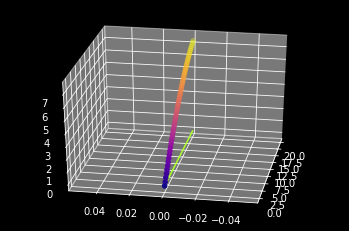

In [ ]:
# project planar trajectory into 3D space for further modification
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, 0, calc(x), c=calc(x), cmap='plasma');
line = plt3d.art3d.Line3D(x, 0, alt, c='greenyellow')
ax.add_line(line)
ax.view_init(elev=30, azim=190)

This takes in variables regarding the distance of the package from to pivot point or wings and the degrees per second of rotation. This then calculates the Y velocity and corrects the X and Z velocity components to account for angular momentum gained in the swinging of the package underneath the drone.
______________


[0, 25, -0.07322280421063715, 10.654515530617093]
10.654515530617093
25
0.047474797926883396 12.499999999999998 21.65063509461097


/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


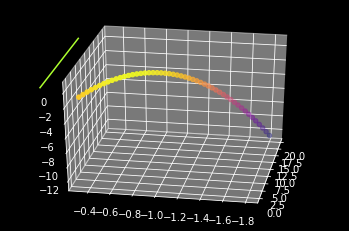

In [ ]:
 # rotate parent with package d distance from the pivot point of parent and generating a lateral vector to change drop direction without altering parent yaw


d = 0.5 # pivot to package in meters
degs = 10 #degrees per second from hanging down to sides
sec = 1 #seconds of rotation
VyR = (d * (degs * np.pi)/180)/sec #calc the tangential velocity
chord = 2*d*np.sin((degs*sec)/2) # dist from package to package rotation
displace = d*np.cos((90-degs*sec)/2) # total rotation (over 360)
VyX = (VyR/sec) * np.cos((-degs)*sec) # tangential velocity (outwards)
VzX = (VyR/sec) * np.sin((-degs)*sec) # tangential velocity (vertically)
dh = np.sin(180-(degs*sec)/4)*(chord) # difference in start height with rotation (adjusts initial height of drop)
uvel = 10 + np.tan((VzX+Vz0)/Vx0) # total velocity with x and y elements
vecc = [0, v0 , VyX, uvel] # quaternion [rotational velocity, forward velocity (X), sideways velocity (Y), vertical velocity (Z)]

# quaternion of the package velocity
print("velocityVector: " + vecc)
# sum of all planar velocities of package
print(uvel)
# initial planar x velocity
print(vel)
# velocity components
print(VzX, Vz0, Vx0)

def upcalc(x):
    narch = ((alt + dh) + x*np.tan(ang)) - (gra * x**2)/(2 * uvel**2 * np.cos(ang)**2)
    return narch

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, (x * vecc[2])+displace, upcalc(x), c=upcalc(x), cmap='plasma');
line = plt3d.art3d.Line3D(x, 0, alt, c='greenyellow')
ax.add_line(line)
ax.view_init(elev=30, azim=190)

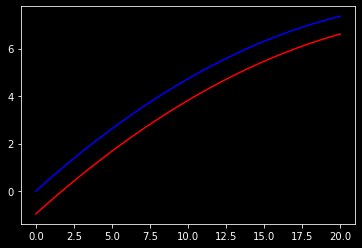

In [ ]:
# trajectory corrected for additional velocity from rotation
plt.plot(x, upcalc(x), 'r')
# uncorrected planar trajectory
plt.plot(x, calc(x), 'b')

Begins to account for drag on the package. Currently uses drag coefficent of cube to approximate the lost in range the package will experience throughout its drop. Assumes drops occurs near sea level with a fairly light package, though this seems fairly realistic for its applications. 

<<< WILL FIX LATER >>>

In [ ]:
m = 1 #mass kg
dens = 1.225 # desity of air
sX = 0.25 # SA x axis
sY = 0.25 # SA y axis
dcX = 0.8 # drag coefficent x axis
dcY = 0.8 # drag coefficent y axis


def sim():
  # replace uvel with function of x to make graphable
  drop = (2 * m)/(dens * dcX *dcY) * np.log(dcX * dcY * uvel * np.cos(ang) * np.sqrt(dens/(2*m*gra**sX*sY))*(np.arccosh(np.sqrt(((np.sin(ang)**2)*(dens*sX*sY*uvel**2)/(2 * m * gra))+1)) + np.arctan(uvel * np.sin(ang) * np.sqrt((dens * sX *sY * uvel**2)/(2 * m * gra)))+1))
  # ^^ Diagonal distance
  dropX = (2 * m)/(dens * dcX *dcY) * np.log(dcX * dcY * vel * np.cos(ang) * np.sqrt(dens/(2*m*gra**sX*sY))*(np.arccosh(np.sqrt(((np.sin(ang)**2)*(dens*sX*sY*vel**2)/(2 * m * gra))+1)) + np.arctan(vel * np.sin(ang) * np.sqrt((dens * sX *sY * vel**2)/(2 * m * gra)))+1))
  # ^^ Forward distance w/ only forward velocity
  dropY = (2 * m)/(dens * dcX *dcY) * np.log(dcX * dcY * VyX * np.cos(ang) * np.sqrt(dens/(2*m*gra**sX*sY))*(np.arccosh(np.sqrt(((np.sin(ang)**2)*(dens*sX*sY*VyX**2)/(2 * m * gra))+1)) + np.arctan(VyX * np.sin(ang) * np.sqrt((dens * sX *sY * VyX**2)/(2 * m * gra)))+1))
  # ^^ Sideways distance w/ only sideways velocity
  print(uvel, vel, VyX)
  print(drop, dropX, dropY)
  #return drop
sim()

25.654515530617093 25 -0.07322280421063715
10.19831379613479 10.117764615638318 nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
